# Continuous Control - Reacher Environment
This notebook uses Deep Deterministic Policy Gradients (DDPG) to solve the continuous control problem for the Reacher environment.

## I. Preparation

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import deque
from unityagents import UnityEnvironment
from ddpg_agent import Agents

In [2]:
def ddpg(n_episodes=200, max_t=1000, print_every=10, rolling_window=100, 
         output_actor='checkpoint_actor.pth', output_critic='checkpoint_critic.pth'):
    # Initialize
    scores_pass = 30
    solved = False
    brain_name = env.brain_names[0]
    scores_deque = deque(maxlen=rolling_window)
    scores = []
    # Iterate through episodes
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agents.reset()
        score = np.zeros(agents.n_agents)
        for t in range(max_t):
            actions = agents.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done         
            agents.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        # Print results
        print('\rEpisode {} \tAverage Score: {:.2f} \tLatest Score: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
        if i_episode % print_every == 0:
            print('')
        # Save
        if np.mean(scores_deque)>=scores_pass:
            if solved == False:
                print('\n * Environment first solved in {:d} episodes! Average Score: {:.2f}. Continue training...'.format(i_episode, np.mean(scores_deque)))
                solved = True
            scores_pass = np.mean(scores_deque)
            torch.save(agents.actor_local.state_dict(), output_actor)
            torch.save(agents.critic_local.state_dict(), output_critic)
    return scores

def plot_score(scores, rolling_window=100):
    df_scores = pd.DataFrame(scores, columns=['EpisodeScore'])
    df_scores['MovingAvg100'] = df_scores['EpisodeScore'].rolling(rolling_window, min_periods=1).mean()
    df_scores.plot(color=['grey', 'red'])
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## II. Environment

In [3]:
# Set up the environment
env = UnityEnvironment(file_name='Reacher_multiple_agents\Reacher.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## III. Train the Agents

In [4]:
# Train model or load model
train_model = True

Episode 10 	Average Score: 0.94 	Latest Score: 1.07
Episode 20 	Average Score: 2.57 	Latest Score: 7.89
Episode 30 	Average Score: 5.24 	Latest Score: 13.67
Episode 40 	Average Score: 7.99 	Latest Score: 20.14
Episode 50 	Average Score: 11.97 	Latest Score: 34.26
Episode 60 	Average Score: 16.07 	Latest Score: 35.68
Episode 70 	Average Score: 19.02 	Latest Score: 36.87
Episode 80 	Average Score: 21.16 	Latest Score: 36.43
Episode 90 	Average Score: 22.88 	Latest Score: 36.08
Episode 100 	Average Score: 24.03 	Latest Score: 35.18
Episode 110 	Average Score: 27.38 	Latest Score: 30.99
Episode 119 	Average Score: 30.12 	Latest Score: 35.37
 * Environment first solved in 119 episodes! Average Score: 30.12. Continue training...
Episode 120 	Average Score: 30.41 	Latest Score: 36.85
Episode 130 	Average Score: 33.06 	Latest Score: 37.17
Episode 140 	Average Score: 35.11 	Latest Score: 35.58
Episode 150 	Average Score: 35.97 	Latest Score: 36.64
Episode 160 	Average Score: 35.95 	Latest Score

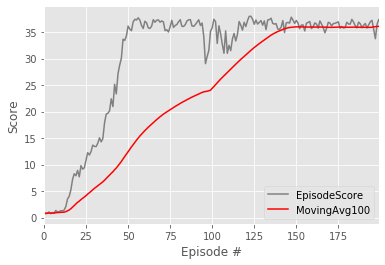

In [5]:
# Environment Info
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_actor = 'checkpoint_actor.pth'
output_critic = 'checkpoint_critic.pth'
n_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

# Agents
agents = Agents(state_size=state_size, action_size=action_size, n_agents=n_agents, random_seed=7, device=device)
if train_model:
    scores = ddpg(output_actor=output_actor, output_critic=output_critic)
    plot_score(scores)
else:
    agents.actor_local.load_state_dict(torch.load(output_actor))
    agents.critic_local.load_state_dict(torch.load(output_critic))

## IV. Watch the Smart Agents

In [27]:
# Watch the trained agent
env_info = env.reset(train_mode=False)[brain_name] 
states = env_info.vector_observations
scores = np.zeros(n_agents)
while True:
    actions = agents.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards 
    dones = env_info.local_done
    scores += rewards
    states = next_states 
    if np.any(dones):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
# env.close()

Total score (averaged over agents) this episode: 38.26649914467707
